# Flow Matching Step Comparison
This notebook loads the trained models once and allows you to experiment with 
different ODE solver step counts to find the balance between speed and quality.

In [1]:
import os

# Allow PyTorch to fall back to CPU for operations missing on MPS
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import sys
import torch
import matplotlib.pyplot as plt
import IPython.display as ipd

sys.path.append("../src")

from src.text_processing import text_to_sequence
from src.symbols import symbol_to_id
from src.model import AcousticModel
from src.decoder import FlowMatchingDecoder
from src.length_regulator import LengthRegulator
from speechbrain.inference.vocoders import HIFIGAN

/Users/martinledl/Developer/nano-tts/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
torchvision is not available - cannot save figures


## 1. Configuration & Model Loading
We load the models globally so we don't reload them for every test.

In [2]:
# --- CONFIG ---
AM_CKPT = "../pretrained_models/duration_model.pth"
FM_CKPT = "../pretrained_models/second_dataset/gen2/flow_matching_decoder_ema_best.pt"
CONFIG_PATH = "../configs/model_config.yaml"
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

MEL_MEAN = -5.521275
MEL_STD = 2.065534
SILENCE_MEL_VAL = -11.51
SPN_ID = symbol_to_id.get("spn", symbol_to_id.get("sil", 0))

print(f"Using Device: {DEVICE}")

Using Device: mps


In [3]:
import yaml

def load_models_notebook(config_path, am_path, fm_path, device):
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)

    # Acoustic Model
    am_conf = config['acoustic_model']
    am = AcousticModel(
        encoder_dim=am_conf['encoder_dim'],
        hidden_dim=am_conf['hidden_dim'],
        n_heads=am_conf['n_heads'],
        encoder_layers=am_conf['encoder_layers'],
        encoder_dropout=am_conf['encoder_dropout'],
        duration_predictor_hidden_dim=am_conf['duration_predictor_hidden_dim'],
        duration_predictor_dropout=am_conf['duration_predictor_dropout']
    ).to(device)

    # Flow Decoder
    fm_conf = config.get('flow_matching_decoder', config.get('flow_model'))
    decoder = FlowMatchingDecoder(
        input_dim=fm_conf['input_dim'],
        output_dim=fm_conf['output_dim'],
        hidden_dim=fm_conf['hidden_dim'],
        n_layers=fm_conf['n_layers'],
        n_heads=fm_conf['n_heads'],
        dropout=fm_conf['dropout']
    ).to(device)

    # Load Weights
    print("Loading weights...")
    am.load_state_dict(torch.load(am_path, map_location=device, weights_only=True))
    decoder.load_state_dict(torch.load(fm_path, map_location=device, weights_only=True))

    am.eval()
    decoder.eval()
    return am, decoder

# Load models (Run this cell only once)
acoustic_model, flow_decoder = load_models_notebook(CONFIG_PATH, AM_CKPT, FM_CKPT, DEVICE)
length_regulator = LengthRegulator().to(DEVICE)

# Print model number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Acoustic Model Parameters: {count_parameters(acoustic_model):,}")
print(f"Flow Matching Decoder Parameters: {count_parameters(flow_decoder):,}")

# Load Vocoder
print("Loading HiFi-GAN...")
hifi_gan = HIFIGAN.from_hparams(
    source="speechbrain/tts-hifigan-ljspeech",
    savedir="../pretrained_models/hifigan-ljspeech",
    run_opts={"device": DEVICE}
)
print("Models Ready.")


Loading weights...


/Users/martinledl/Developer/nano-tts/venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/martinledl/Developer/nano-tts/venv/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Acoustic Model Parameters: 9,199,873
Flow Matching Decoder Parameters: 38,108,240
Loading HiFi-GAN...
Models Ready.


/Users/martinledl/Developer/nano-tts/venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


## 2. Inference Function
A modified version of the inference script that returns the audio and spectrogram instead of saving to disk.


In [4]:
def generate_audio(text, steps=50, n_pad=20):
    # Text to Sequence
    sequence = text_to_sequence(text)
    
    # Append silence token (Pad)
    silence_token = torch.tensor([SPN_ID], dtype=torch.long)
    sequence = torch.cat([sequence, silence_token], dim=0)
    
    phonemes = sequence.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        # Duration Prediction
        log_durations, encoder_outputs = acoustic_model(phonemes)
        durations = torch.exp(log_durations) - 1
        durations = torch.clamp(durations, min=1).round().long()
        
        # Align Text
        aligned_text = length_regulator(encoder_outputs, durations)
        batch_size, seq_len, _ = aligned_text.shape
        
        # Flow Matching (ODE Solver)
        x = torch.randn(batch_size, seq_len, 80).to(DEVICE)
        mask = torch.ones(batch_size, seq_len).to(DEVICE)
        dt = 1.0 / steps
        
        # The Loop
        for i in range(steps):
            t_scalar = i / steps
            t = torch.tensor([t_scalar], device=DEVICE).view(batch_size, 1)
            v_pred = flow_decoder(x, mask, aligned_text, t)
            x = x + v_pred * dt

        # Add Silence Padding (Tail)
        if n_pad > 0:
            padding = torch.full((batch_size, n_pad, 80), SILENCE_MEL_VAL, device=DEVICE)
        
        # Denormalize
        x = x * MEL_STD + MEL_MEAN 
        
        if n_pad > 0:
            x = torch.cat([x, padding], dim=1)
        
        # Vocode
        # Input to SB HiFiGAN: [Batch, Mels, Time]
        x_vocoder = x.transpose(1, 2)
        waveform = hifi_gan.decode_batch(x_vocoder)
        
        return waveform.squeeze().cpu(), x.squeeze().cpu()


## 3. The Comparison Test
Run this cell to hear the difference between step counts.


Generating: 'This is an audio generated by a text to speech model made by Martin from scratch. Follow me for more projects like this!'

--- Generating with 5 steps ---
Step Count: 5


--- Generating with 10 steps ---
Step Count: 10


--- Generating with 25 steps ---
Step Count: 25


--- Generating with 50 steps ---
Step Count: 50


--- Generating with 100 steps ---
Step Count: 100


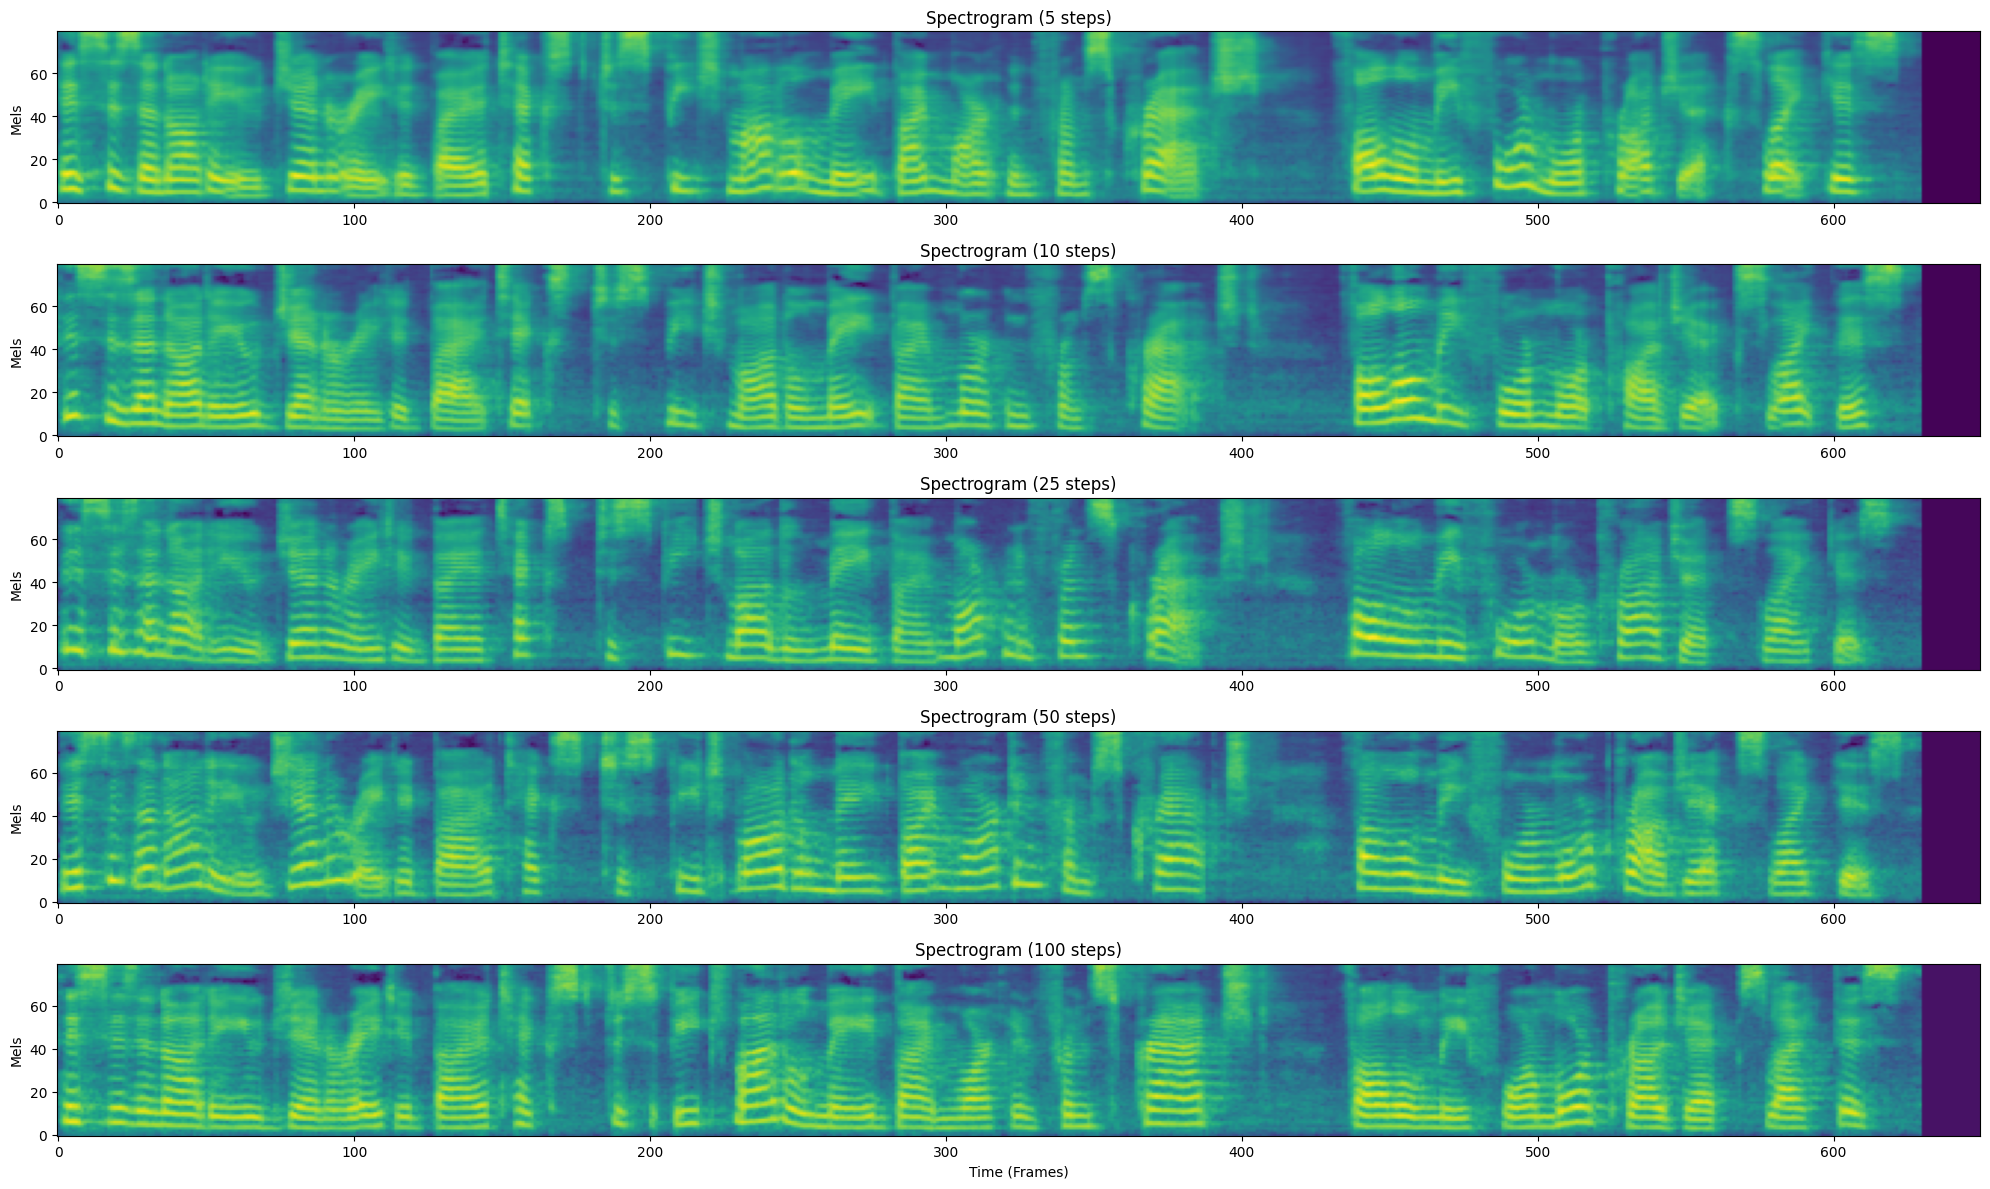

In [7]:
TEST_TEXT = "This is an audio generated by a text to speech model made by Martin from scratch. Follow me for more projects like this!"
STEP_COUNTS = [5, 10, 25, 50, 100]

print(f"Generating: '{TEST_TEXT}'\n")

plt.figure(figsize=(20, 12))

for i, steps in enumerate(STEP_COUNTS):
    print(f"--- Generating with {steps} steps ---")
    
    # Generate
    audio, mel = generate_audio(TEST_TEXT, steps=steps)
    
    # Display Audio Player
    print(f"Step Count: {steps}")
    ipd.display(ipd.Audio(audio, rate=22050))
    
    # Plot Spectrogram
    plt.subplot(len(STEP_COUNTS), 1, i+1)
    plt.imshow(mel.T, origin='lower', aspect='auto', cmap='viridis')
    plt.title(f"Spectrogram ({steps} steps)")
    plt.ylabel("Mels")
    if i == len(STEP_COUNTS)-1:
        plt.xlabel("Time (Frames)")

plt.tight_layout()
plt.show()